In [1]:
from BioLink.biolink_client import BioLinkWrapper
import pandas as pd
from pprint import pprint
from collections import defaultdict
from mygene import MyGeneInfo
from GraphVisuals.graphviz_wrapper import PathGraph

## Module declaration

In [2]:
worklow_modules = [
    ('Mod1A', 'Mod1A Functional Similarity'),
    ('Mod1B', 'Mod1B Phenotype Similarity'),
    ('Mod1C', 'Mod1C Coexpression'),
    ('Mod1D', 'Mod1D Gene Chemical Interaction'),
    ('Mod1E', 'Mod1E Gene Interaction'),
    ('Mod3', 'Mod3 Candidate Merging')
]

In [3]:
# start a list of final candidates from each module
results = list()

## Workflow input

# Mod0 Input Lookup
## Get Disease associated genes from BioLink API api.monarchinitative.org

In [4]:
from Modules.Mod0_lookups import LookUp

# workflow input is a disease identifier
lu = LookUp()

Mod O DiseaseGeneLookup metadata:
{'data_type': 'disease',
 'input_type': {'complexity': 'single', 'id_type': ['MONDO', 'DO', 'OMIM']},
 'limit': None,
 'output_type': {'complexity': 'set', 'id_type': 'HGNC'},
 'predicate': 'blm:gene associated with condition',
 'source': 'Monarch Biolink',
 'taxon': 'human'}


In [5]:
input_disease = 'MONDO:0008310' # progeria   
input_object = {
    'input': input_disease,
    'parameters': {
        'taxon': 'human',
        'threshold': None,
    },
}

lu.load_input_object(input_object=input_object)
input_object = lu.input_object

{'description': 'Hutchinson-Gilford progeria syndrome is a rare, fatal, '
                'autosomal dominant and premature aging disease, beginning in '
                'childhood and characterized by growth reduction, failure to '
                'thrive, a typical facial appearance (prominent forehead, '
                'protuberant eyes, thin nose with a beaked tip, thin lips, '
                'micrognathia and protruding ears) and distinct dermatologic '
                'features (generalized alopecia, aged-looking skin, sclerotic '
                'and dimpled skin over the abdomen and extremities, prominent '
                'cutaneous vasculature, dyspigmentation, nail hypoplasia and '
                'loss of subcutaneous fat).',
 'id': 'MONDO:0008310',
 'label': 'progeria'}


In [6]:
# instantiate workflow graph
path_graph = PathGraph(input_curie=input_object['id'], input_label=input_object['label'])
path_graph.load_nodes(node_list=worklow_modules)

In [7]:
# get genes associated with disease from Biolink
disease_associated_genes = lu.disease_geneset_lookup()
# create list of gene curies for downstream module input
input_curie_set = disease_associated_genes['hit_id'].tolist()
# # show the 
disease_associated_genes

,input_id,input_label,hit_id,hit_label,ncbi,sources
0,MONDO:0008310,progeria,HGNC:12877,ZMPSTE24,NCBIGene:10269,"ctd, orphane"
1,MONDO:0008310,progeria,HGNC:17397,BANF1,NCBIGene:8815,"omim, ctd, orphane, clinvar"
2,MONDO:0008310,progeria,HGNC:25356,SPRTN,NCBIGene:83932,ctd
3,MONDO:0008310,progeria,HGNC:494,ANK3,NCBIGene:288,ctd
4,MONDO:0008310,progeria,HGNC:6636,LMNA,NCBIGene:4000,"ctd, omim, orphane, clinvar, corie"
5,MONDO:0008310,progeria,HGNC:9721,PYCR1,NCBIGene:5831,ctd


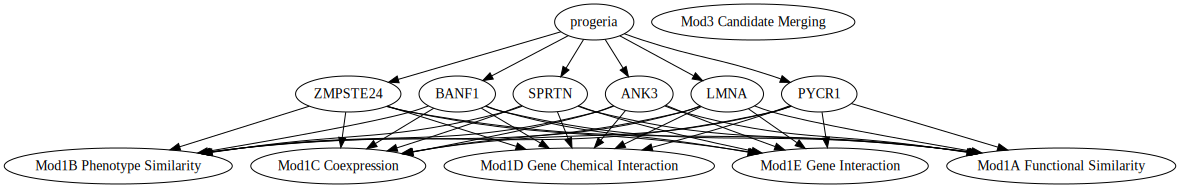

In [8]:
# graph disease genes 2 mod1
path_graph.load_nodes(list(zip(disease_associated_genes['hit_id'], disease_associated_genes['hit_label'])))
path_graph.module_outputs(output_gene_set=input_curie_set, module_id=path_graph.conv_pref(input_disease))
for module in worklow_modules[:-1]:
    path_graph.module_inputs(input_gene_set=input_curie_set, module_id=module[0])
path_graph.path_graph

In [9]:
# add Mod0 results to ouput
for index, row in disease_associated_genes.iterrows():
    results.append({
        'input_curie': row[0],
        'input_name': row[1],
        'output_curie': row[2],
        'output_name': row[3],
        'module': 'Mod0',
        'score': None,
    }) 

# Mod1A Functional Similarity
## Find similar genes based on GO functional annotations using OntoBio Jaccard similarity

In [10]:
from Modules.Mod1A_functional_sim import FunctionalSimilarity

# Module specification
mod1a_input_object = {
    'input': input_curie_set,
    'parameters': {
        'taxon': 'human',
        'threshold': 0.3,
    },
}
    
func_sim = FunctionalSimilarity()

/Users/tputman/.virtualenvs/modules/lib/python3.6/site-packages/cachier/mongo_core.py:24: UserWarning: Cachier warning: pymongo was not found. MongoDB cores will not work.
  "Cachier warning: pymongo was not found. MongoDB cores will not work.")


Mod1A Functional Similarity metadata:
{'input_type': {'complexity': 'set', 'data_type': 'gene', 'id_type': 'HGNC'},
 'output_type': {'complexity': 'set', 'data_type': 'gene', 'id_type': 'HGNC'},
 'predicate': ['blm:macromolecular machine to biological process association',
               'macromolecular machine to molecular activity association'],
 'source': 'Monarch Biolink'}


In [11]:
mod1a_input_object = {
    'input': input_curie_set,
    'parameters': {
        'taxon': 'human',
        'threshold': 0.75,
    },
}
func_sim.load_input_object(mod1a_input_object)
func_sim.load_gene_set() 
func_sim.load_associations()

In [12]:
Mod1A_results = pd.DataFrame(func_sim.compute_similarity())

In [13]:
Mod1A_results = Mod1A_results[~Mod1A_results['hit_curie'].isin(input_curie_set)]

In [14]:
Mod1A_results

,hit_curie,hit_name,hit_score,input_curie,input_name


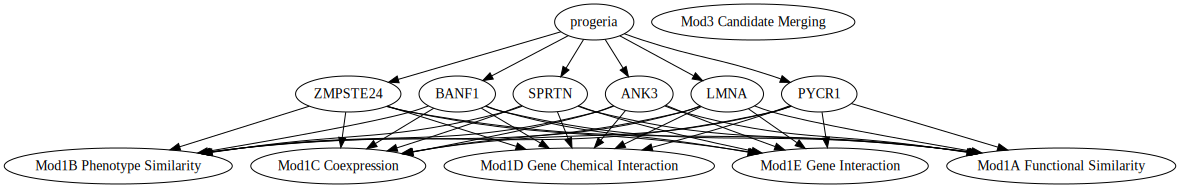

In [15]:
path_graph.load_nodes(list(zip(Mod1A_results['hit_curie'], Mod1A_results['hit_name'])))
path_graph.module_inputs(input_gene_set=Mod1A_results['hit_curie'].tolist(), module_id='Mod3')
path_graph.module_outputs(output_gene_set=Mod1A_results['hit_curie'].tolist(), module_id='Mod1A')
path_graph.path_graph

In [16]:
# add Mod1A results to ouput
for index, row in Mod1A_results.iterrows():
    results.append({
        'input_curie': row[0],
        'input_name': row[1],
        'output_curie': row[2],
        'output_name': row[3],
        'module': 'Mod1A',
        'score': row[4],
    }) 

# MOD1B Phenotype Similarity
## Find similar genes based on OwlSim calculated Phenotype Similarity

In [17]:
from Modules.Mod1B_phenotype_similarity import PhenotypeSimilarity

mod1b_input_object = {
    'input': input_curie_set,
     'parameters': {
        'taxon': 'human',
        'threshold': 100,
    },
}

# Module specification
pheno_sim = PhenotypeSimilarity()

Mod1B Phenotype Similarity metadata:
{'input_type': {'complexity': 'set', 'data_type': 'gene', 'id_type': 'HGNC'},
 'output_type': {'complexity': 'set', 'data_type': 'gene', 'id_type': 'HGNC'},
 'predicate': ['blm:has phenotype'],
 'source': 'Monarch Biolink'}


In [18]:
pheno_sim.load_input_object(mod1b_input_object)
pheno_sim.load_gene_set()
pheno_sim.load_associations()

In [19]:
# compute phenotype similarity
Mod1B_results = pd.DataFrame(pheno_sim.compute_similarity(sim_type='disease'))

In [20]:
Mod1B_results

,input_id_x,id,label_x,summed_score
0,HGNC:12877,MONDO:0008310,progeria,160.0
1,HGNC:12877,MONDO:0010143,lethal restrictive dermopathy,144.0
2,HGNC:12877,MONDO:0012074,mandibuloacral dysplasia with type B lipodystr...,162.0
3,HGNC:12877,MONDO:0009557,mandibuloacral dysplasia with type A lipodystr...,157.0
4,HGNC:12877,MONDO:0016584,mandibuloacral dysplasia,150.0
5,HGNC:12877,MONDO:0017230,autosomal semi-dominant severe lipodystrophic ...,138.0
6,HGNC:12877,MONDO:0010585,X-linked hypohidrotic ectodermal dysplasia,135.0
7,HGNC:12877,MONDO:0007057,acroosteolysis dominant type,143.0
9,HGNC:12877,MONDO:0009910,Wiedemann-Rautenstrauch syndrome,131.0
12,HGNC:12877,MONDO:0013523,Nestor-Guillermo progeria syndrome,166.0


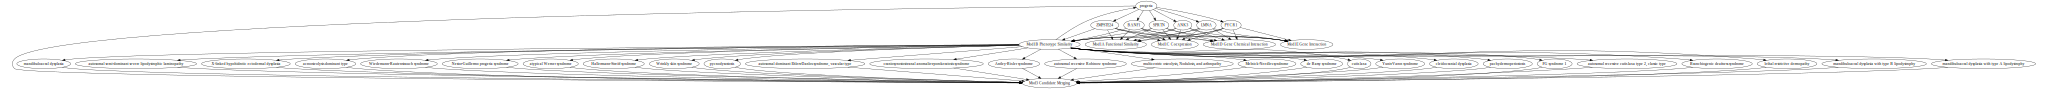

In [21]:
path_graph.load_nodes(list(zip(Mod1B_results['id'], Mod1B_results['label_x'])))
path_graph.module_outputs(output_gene_set=Mod1B_results['id'].tolist(), module_id='Mod1B')
path_graph.module_inputs(input_gene_set=Mod1B_results['id'].tolist(), module_id='Mod3')
path_graph.path_graph

In [22]:
# graph mod1B genes 2 Mod3
for index, row in Mod1B_results.iterrows():
    results.append({
        'input_curie': row[-1],
        'input_name': None,
        'output_curie': row[1],
        'output_name': row[2],
        'module': 'Mod1B',
        'score': row[3]
    }) 

# Mod1C Coexpression

In [23]:
# TODO

# Mod1D Chemical Gene Interactions

In [24]:
# TODO

# Mod1E Gene Interactions

In [25]:
from Modules.Mod1E_interactions import GeneInteractions
gene_inter = GeneInteractions()

Mod1E Interaction Network metadata:
{'input_type': {'complexity': 'set', 'data_type': 'gene', 'id_type': 'HGNC'},
 'output_type': {'complexity': 'set', 'data_type': 'gene', 'id_type': 'HGNC'},
 'predicate': ['blm:interacts with'],
 'source': 'Monarch Biolink'}


In [26]:
mod1e_input_object = {
    'input': input_curie_set,
     'parameters': {
        'taxon': 'human',
        'threshold': None,
    },
}
gene_inter.load_input_object(input_object=mod1e_input_object)
gene_inter.load_gene_set()

In [27]:
Mod1E_results = pd.DataFrame(gene_inter.get_interactions())

In [28]:
Mod1E_results

,hit_curie,hit_name,hit_score,input_curie,input_label
0,HGNC:468,AMPD1,None,HGNC:12877,ZMPSTE24
1,HGNC:10934,SLC18A1,None,HGNC:12877,ZMPSTE24
2,HGNC:11010,SLC2A5,None,HGNC:12877,ZMPSTE24
3,HGNC:28779,TMPRSS12,None,HGNC:12877,ZMPSTE24
4,HGNC:3785,FNTB,None,HGNC:12877,ZMPSTE24
5,HGNC:28804,GDPD5,None,HGNC:12877,ZMPSTE24
6,HGNC:24519,TCTN3,None,HGNC:12877,ZMPSTE24
7,HGNC:3312,ELAVL1,None,HGNC:12877,ZMPSTE24
8,HGNC:2767,DEFB4A,None,HGNC:12877,ZMPSTE24
9,HGNC:16690,GJB7,None,HGNC:12877,ZMPSTE24


In [29]:
Mod1E_results = Mod1E_results[~Mod1E_results['hit_name'].isin(disease_associated_genes['hit_label'])]

In [30]:
grouped_Mod1E_results = Mod1E_results.groupby(['hit_curie', 'hit_name'])['input_curie'].apply(', '.join).reset_index()
trimmed_Mod1E_results = list()
for index, row in grouped_Mod1E_results.iterrows():
    if len(row[-1].split(',')) > 3:
        trimmed_Mod1E_results.append(row)
Mod1E_results = pd.DataFrame(trimmed_Mod1E_results, columns=['hit_curie', 'hit_name', 'input_curie']).reset_index()
Mod1E_results

,index,hit_curie,hit_name,input_curie


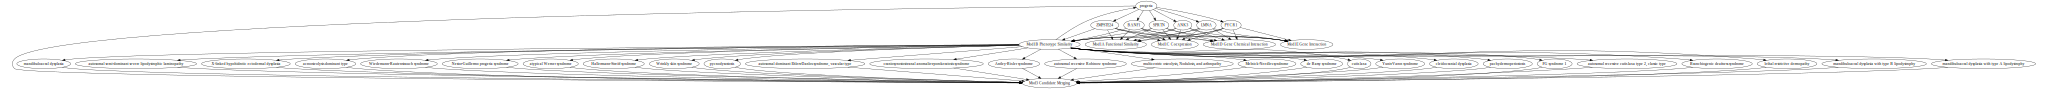

In [31]:
path_graph.load_nodes(list(zip(Mod1E_results['hit_curie'], Mod1E_results['hit_name']))[:10])
path_graph.module_outputs(output_gene_set=Mod1E_results['hit_curie'].tolist()[:10], module_id='Mod1E')
path_graph.module_inputs(input_gene_set=Mod1E_results['hit_curie'].tolist()[:10], module_id='Mod3')
path_graph.path_graph

In [32]:
# graph mod1E genes 2 Mod3
for index, row in Mod1E_results.iterrows():
    results.append({
        'input_curie': row[-1],
        'input_name': None,
        'output_curie': row[1],
        'output_name': row[2],
        'module': 'Mod1E',
        'score': None
    })

In [33]:
results_df = pd.DataFrame(results)

In [34]:
results_df

,input_curie,input_name,module,output_curie,output_name,score
0,MONDO:0008310,progeria,Mod0,HGNC:12877,ZMPSTE24,NaN
1,MONDO:0008310,progeria,Mod0,HGNC:17397,BANF1,NaN
2,MONDO:0008310,progeria,Mod0,HGNC:25356,SPRTN,NaN
3,MONDO:0008310,progeria,Mod0,HGNC:494,ANK3,NaN
4,MONDO:0008310,progeria,Mod0,HGNC:6636,LMNA,NaN
5,MONDO:0008310,progeria,Mod0,HGNC:9721,PYCR1,NaN
6,160,None,Mod1B,MONDO:0008310,progeria,160.0
7,144,None,Mod1B,MONDO:0010143,lethal restrictive dermopathy,144.0
8,162,None,Mod1B,MONDO:0012074,mandibuloacral dysplasia with type B lipodystr...,162.0
9,157,None,Mod1B,MONDO:0009557,mandibuloacral dysplasia with type A lipodystr...,157.0


In [35]:
results_df.groupby(['output_name', 'output_curie'])['module'].apply(', '.join).reset_index().reset_index()

,index,output_name,output_curie,module
0,0,ANK3,HGNC:494,Mod0
1,1,Antley-Bixler syndrome,MONDO:0008803,Mod1B
2,2,BANF1,HGNC:17397,Mod0
3,3,Branchiogenic deafness syndrome,MONDO:0012209,Mod1B
4,4,FG syndrome 1,MONDO:0010590,Mod1B
5,5,Hallermann-Streiff syndrome,MONDO:0009318,Mod1B
6,6,LMNA,HGNC:6636,Mod0
7,7,Melnick-Needles syndrome,MONDO:0010650,Mod1B
8,8,Nestor-Guillermo progeria syndrome,MONDO:0013523,Mod1B
9,9,PYCR1,HGNC:9721,Mod0
